# Purpose of this simulation


# ideas

In [1]:

#for comparision
exp_conds = ['wo_feature_selection', 
             'w_iter_feature_selection']

for e in exp_conds: print(e)


wo_feature_selection
w_iter_feature_selection


# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)

mean_firing_rate_low = 100
mean_firing_rate_high = 100
noise_mode = 'fixed_gaussian'
fixed_noise_level = 0 #Hz

#change the exp_conds

exp_conds = [e + f'_mfr_100' for e in exp_conds]

print(exp_conds)

['wo_feature_selection_mfr_100', 'w_iter_feature_selection_mfr_100']


In [3]:


neuron_types = ['noisy', 'non_noisy']

n_neurons = 32
n_neurons_noisy_group = 24
n_neurons_no_noise_group = 8


noise_neuron_ind = np.arange(n_neurons_noisy_group)
no_noise_neuron_ind = np.arange(n_neurons_noisy_group, n_neurons_noisy_group + n_neurons_no_noise_group)

neuron_type_indices_in_a_list = [
    noise_neuron_ind, 
    no_noise_neuron_ind
]


noise_neuron_list = np.full(n_neurons, False, dtype = bool)
no_noise_neuron_list = np.full(n_neurons, False, dtype = bool)


noise_neuron_list[noise_neuron_ind] = True
no_noise_neuron_list[no_noise_neuron_ind] = True



neuron_type_bool_list = [
    noise_neuron_list,
    no_noise_neuron_list,
]

N_TYPES_OF_NEURONS = 2

print('We have two types of indices: ')
for t,l in enumerate(neuron_type_indices_in_a_list): print(f'{neuron_types[t]}:{l}')


We have two types of indices: 
noisy:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
non_noisy:[24 25 26 27 28 29 30 31]


In [4]:
percent_of_count = np.ones(n_neurons)[:, np.newaxis]
print(f'set up the variances in a list:')

percent_of_count[noise_neuron_ind] =  1
percent_of_count[no_noise_neuron_ind] = 1

print(f'we therefore know the number of neurons to be {n_neurons}')


set up the variances in a list:
we therefore know the number of neurons to be 32


In [5]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 200

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [6]:
GLOBAL_FIGURE_VERTICAL_SIZE = 4

In [7]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow, SimpleTargetCapture
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train


from behaviour_metrics import  filter_state, sort_trials

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


##  behaviour and task setup

In [8]:
#seq = SimBMIControlMulti.sim_target_seq_generator_multi(
#N_TARGETS, N_TRIALS)

from target_capture_task import ConcreteTargetCapture
seq = ConcreteTargetCapture.out_2D()

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = True
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = SimpleTargetCapture

#for adding experimental features such as encoder, decoder
feats = []
feats_2 = []
feats_set = [] # this is a going to be a list of lists 

## Additional task setup

In [9]:
from simulation_features import TimeCountDown
from features.sync_features import HDFSync


feats.append(HDFSync)
feats_2.append(HDFSync)

feats.append(TimeCountDown)
feats_2.append(TimeCountDown)

total_exp_time = 300# in seconds

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [10]:
from features.simulation_features import get_enc_setup

ENCODER_TYPE = 'cosine_tuned_encoder_with_poisson_noise'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'rot_90', n_neurons= n_neurons)

#multiply our the neurons
sim_C[noise_neuron_list] =  sim_C[noise_neuron_list]  * mean_firing_rate_low
sim_C[no_noise_neuron_list]  = sim_C[no_noise_neuron_list] * mean_firing_rate_high




#set up the encoder
from features.simulation_features import SimCosineTunedEncWithNoise
#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)
feats.append(SimCosineTunedEncWithNoise)


feats_2.append(SimIntentionLQRController)
feats_2.append(SimCosineTunedEncWithNoise)

features.simulation_features: get_enc_setup has a tuning_level of 1 



## decoder setup

In [11]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    feats_2.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    feats_2.append(SimKFDecoderSup)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [12]:

#setting clda parameters 
##learner: collects paired data at batch_sizes
RHO = 0.01
batch_size = 100

#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)



LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
    feats_2.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)
    feats_2.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
    feats_2.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')

## feature selector setup

In [13]:
from feature_selection_feature import FeatureTransformer, TransformerBatchToFit
from feature_selection_feature import FeatureSelector, LassoFeatureSelector, SNRFeatureSelector, IterativeFeatureSelector
from feature_selection_feature import ReliabilityFeatureSelector


#pass the real time limit on clock
feats.append(FeatureSelector)
feats_2.append(ReliabilityFeatureSelector)


feature_x_meth_arg = [
    ('transpose', None ),
]

kwargs_feature = dict()
kwargs_feature = {
    'transform_x_flag':False,
    'transform_y_flag':False,
    'n_starting_feats': n_neurons,
    'n_states':  7
}

print('kwargs will be updated in a later time')
print(f'the feature adaptation project is tracking {kwargs_feature.keys()} ')

kwargs will be updated in a later time
the feature adaptation project is tracking dict_keys(['transform_x_flag', 'transform_y_flag', 'n_starting_feats', 'n_states']) 


## assistor setup

In [14]:
#assistor set up assist level
assist_level = (0.0, 0.0)

## (Check) config the experiment

In [15]:
exp_feats = [feats, feats_2, feats]
exp_feats

[[features.sync_features.HDFSync,
  simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmoothBatch,
  feature_selection_feature.FeatureSelector],
 [features.sync_features.HDFSync,
  simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmoothBatch,
  feature_selection_feature.ReliabilityFeatureSelector],
 [features.sync_features.HDFSync,
  simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimK

In [16]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: 
    feats.append(SaveHDF)
    feats_2.append(SaveHDF)
if SAVE_SIM_HDF: 
    feats.append(SimHDF)
    feats_2.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)

feats_2.append(SimClockTick)
feats_2.append(SimTime)


In [17]:
kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['total_exp_time'] = total_exp_time
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C
    
    d['noise_neuron_list'] = noise_neuron_list
    d['noise_mode'] = noise_mode
    d['percent_noise'] = percent_of_count
    d['fixed_noise_level'] = fixed_noise_level
    
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    
    d.update(kwargs_feature)
    
    kwargs_exps.append(d)

# kwargs_exps[1]['init_feat_set'] = np.full(N_NEURONS, True, dtype = bool)


# kwargs_exps[2]['init_feat_set'] = np.full(N_NEURONS, False, dtype = bool)
# kwargs_exps[2]['init_feat_set'][no_noise_neuron_list] = True

print(f'we have got {len(kwargs_exps)} exps')
kwargs_exps

we have got 2 exps


[{'total_exp_time': 300,
  'assist_level': (0.0, 0.0),
  'sim_C': array([[   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],
         [   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],
         [   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0., -100.,    0.],
         [   0.,    0.,    0.,  100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,  100.,    0.],
         [   0.,    0.,    0., -100.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.

## make and initalize experiment instances

In [18]:
#seed the experiment
np.random.seed(0)


exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    #spawn the task
    f = exp_feats[i]
    Exp = experiment.make(base_class, feats=f)
    
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)


exps_np  = np.array(exps, dtype = 'object')
#run the ini
for e in exps_np: 
    #e.init()
    print('next')
    print()



features.simulation_features.SimIntentionLQRController: LQRController used 


 features.simulation_features.SimFeedbackLearner: start to create a sim leaner with a batchsize of 100
features.simulation_features.SimSmoothBatch: rho in this simulation is  0.9009288012833828

finished executing Experiment.__init__
in feature selector mod
feature init: [array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])]
feature selector: add initial decoder weights
<class 'features.simulation_features.SimCosineTunedEncWithNoise'>: added CosineTunedEncWithNoise 
TimeCountDown: assume  fps to be 60

features.simulation_features.SimIntentionLQRController: LQRController used 


 features.simulation_features.SimFeedbackLearner: start to create a sim leaner with a batchsize of 100
features.simulation_features.Sim

# Pre-experiment check: check the Kalman filter before training

In [19]:
# print('we check the new decoder C matrix:')

# figure_decoder_C, axs_decoder_C = plt.subplots(nrows=2, 
#                                ncols=NUM_EXP, figsize = [GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP, GLOBAL_FIGURE_VERTICAL_SIZE * 2],squeeze = False)
# figure_decoder_C.suptitle('KF C Matrix Before Training ')

# for i,e in enumerate(exps):
#     C = e.decoder.filt.C
#     plot_prefered_directions(C, ax = axs_decoder_C[0,i])
#     axs_decoder_C[0,i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

## actually running the experiments

In [20]:
from feature_selection_feature import run_exp_loop

WAIT_FOR_HDF_FILE_TO_STOP = 10

for i,e in enumerate(exps):
    np.random.seed(0)
    
    e.init()

    run_exp_loop(e, **kwargs_exps[i])
    
    e.hdf.stop()
    print(f'wait for {WAIT_FOR_HDF_FILE_TO_STOP}s for hdf file to save')
    time.sleep(WAIT_FOR_HDF_FILE_TO_STOP)
    
    
    e.save_feature_params()
    
    time.sleep(WAIT_FOR_HDF_FILE_TO_STOP)
    
    e.cleanup_hdf()
   

    e.sinks.reset()
    
    print(f'Finished running  {exp_conds[i]}')
    
    print()
    print()
    




 using encoder with additional noises  State space: ['hand_px', 'hand_py', 'hand_pz', 'hand_vx', 'hand_vy', 'hand_vz', 'offset'] 

<bound method GenericCosEncWithNoise._gen_fixed_gaussian_noise of <riglib.bmi.sim_neurons.GenericCosEncWithNoise object at 0x7efe57da1cd0>>
neural encoder init function  <SimpleTargetCapture(Thread-4, initial)>
features.simulation_features: added tracking of K matrix
sinkmanager start <class 'hdfwriter.hdfwriter.HDFWriter'>
HDFWriter: Saving datafile to /tmp/tmpx1f0pn_a.h5
HDFWriter: opening file
HDFWriter registered 'sync_events'
HDFWriter registered 'sync_clock'
HDFWriter registered 'trials'
HDFWriter registered 'task'
features.simulation_features: batch size is 100
Reset states for learner: 
[]
Done states for learner: 
[]

features.simulation_features.SimFeedbackLearner: flip the self.learn_flag to true
features.simulation_features.SimFeedbackLearner: succussfully created a feedback controller learner


SimSmoothBatch: created an updater with a batch t

/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_O

Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_O

/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
Overwriting [b'TARGET_ON'] with TARGET_ON event
[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.   0.01 0.   0.   0.
 0.   0.   0.   0.  ]
decoder changes here at 2400
(32, 7)
(32, 7)
active feature set is [ True  True False  True False False False False  True  True False False
 False False False False  True False False False  True False False False
  True False False False False False False False]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
Overwriting [b'TARGET_ON'] with TARGET_ON event
[0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.01 0.01 0.   0.
 0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.01 0.   0.   0.01]
decoder chan

[0.   0.   0.01 0.01 0.   0.01 0.01 0.   0.   0.01 0.01 0.   0.   0.
 0.01 0.   0.   0.01 0.   0.01 0.   0.01 0.   0.01 0.   0.   0.01 0.
 0.01 0.   0.01 0.  ]
decoder changes here at 10200
(8, 7)
(8, 7)
active feature set is [False False  True False False False False False False  True False False
 False False False False False False False  True False  True False  True
 False False  True False  True False  True False]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
Overwriting [b'TARGET_ON'] with TARGET_ON event
[0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.01
 0.   0.   0.   0.   0.01 0.   0.   0.01 0.01 0.01 0.01 0.   0.   0.
 0.   0.01 0.   0.  ]
decoder changes here at 10800
(8, 7)
(8, 7)
active feature set is [False False False False False False False  True False False False False
 False  True False False False False  True False False  True  True  True
  True False False False False  True False False]
after trans: (8, 7)
after trans: (8, 

..........................Closed hdf
ended datasink
0
exit
end of FSM.run, task state is None
wait for 10s for hdf file to save
saving file name to /tmp/tmpl6lgv5y2.h5
riglib.bmi.bmi: clda table names
['kf.C', 'kf.Q', 'kf.C_xpose_Q_inv_C', 'kf.C_xpose_Q_inv', 'mFR', 'sdFR', 'rho', 'intended_kin', 'spike_counts_batch']
Finished running  w_iter_feature_selection_mfr_100




In [21]:
data_dump_folder = '/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/'

import shutil

import os
import subprocess

for i,e in enumerate(exps): 

    #shutil.move(e.h5file.name,  data_dump_folder + exp_conds[i] +'.h5')


    import subprocess
    old = e.h5file.name
    new = data_dump_folder + exp_conds[i] +'.h5'
    process = "cp {} {}".format(old,new)
    
    print(process)
    subprocess.run(process, shell=True) # do not remember, assign shell value to True.



cp /tmp/tmpx1f0pn_a.h5 /home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/wo_feature_selection_mfr_100.h5
cp /tmp/tmpl6lgv5y2.h5 /home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/w_iter_feature_selection_mfr_100.h5


# Postprocessing the data for loading

In [22]:
for e in exps: print(f'{e.h5file.name}')


/tmp/tmpx1f0pn_a.h5
/tmp/tmpl6lgv5y2.h5


In [23]:
import aopy
import tables

exp_data_all = list()
exp_data_metadata_all = list()

for i,e in enumerate(exp_conds):
    files = {

    'hdf':e+'.h5'

    }
    
    file_name = os.path.join(data_dump_folder, files['hdf'])

        
    # write in the exp processing files
    
    aopy.data.save_hdf(data_dump_folder, file_name, kwargs_exps[i], data_group="/feature_selection", append = True)
    
    with tables.open_file(file_name, mode = 'r') as f: print(f)
    
    try:
        d,m = aopy.preproc.parse_bmi3d(data_dump_folder, files)
    except:
        print(f'cannot parse {e}')
    
    print(e)

/home/sijia-aw/BMi3D_my/operation_funny_chicken/sim_data/wo_feature_selection_mfr_100.h5 (File) ''
Last modif.: 'Tue Sep 28 14:13:23 2021'
Object Tree: 
/ (RootGroup) ''
/clda (Table(30,), shuffle, zlib(5)) ''
/sync_clock (Table(18000,), shuffle, zlib(5)) ''
/sync_events (Table(255,), shuffle, zlib(5)) ''
/task (Table(18000,), shuffle, zlib(5)) ''
/task_msgs (Table(254,), shuffle, zlib(5)) ''
/trials (Table(127,), shuffle, zlib(5)) ''
/feature_selection (Group) ''
/feature_selection/C_mat (Array(30, 32, 7)) ''
/feature_selection/K_mat (Array(30, 7, 32)) ''
/feature_selection/Q_diag (Array(30, 32)) ''
/feature_selection/assist_level (Array(2,)) ''
/feature_selection/batch_size (Array()) ''
/feature_selection/batch_time (Array()) ''
/feature_selection/feat_set (Array(31, 32)) ''
/feature_selection/fixed_noise_level (Array()) ''
/feature_selection/half_life (Array()) ''
/feature_selection/n_starting_feats (Array()) ''
/feature_selection/n_states (Array()) ''
/feature_selection/noise_mode 

/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/tables/group.py:1201: UserWarning: problems loading leaf ``/feature_selection/noise_mode``::

  variable length strings are not supported yet

The leaf will become an ``UnImplemented`` node.
  warnings.warn(


w_iter_feature_selection_mfr_100


## declare defs and conventions

In [24]:
CENTER_TARGET_ON = 16
CURSOR_ENTER_CENTER_TARGET = 80
CENTER_TARGET_OFF = 32
REWARD = 48
DELAY_PENALTY = 66
TIMEOUT_PENALTY = 65
HOLD_PENALTY = 64
TRIAL_END = 239

In [25]:
from feature_selection_feature import *


## looking at one example data

In [26]:
exp_data, exp_metadata = aopy.preproc.parse_bmi3d(data_dump_folder, files)


clock = exp_data['clock']
print(clock.dtype)
events = exp_data['events']
print(events.dtype)

{'names':['prev_tick','timestamp_bmi3d'], 'formats':['<f8','<f8'], 'offsets':[16,24], 'itemsize':32}
[('time', '<u8'), ('event', 'S32'), ('data', '<u4'), ('code', 'u1'), ('timestamp_bmi3d', '<f8'), ('timestamp', '<f8')]


In [27]:
CURSOR_ENTER_CENTER_TARGET

80

In [28]:
event_names = events['event']
event_cycles = events['time'] # confusingly, 'time' here refers to cycle count

print(events['code'])

target_codes = range(17, 25)



trial_segments, trial_times = aopy.preproc.get_trial_segments(events['code'], event_cycles, target_codes, [REWARD, HOLD_PENALTY, DELAY_PENALTY])
trial_segments = np.array(trial_segments)
print(trial_segments[:10])
print(trial_times[:10])

[238 21 48 20 64 19 48 18 48 22 48 17 48 24 64 23 64 19 64 23 64 20 48 18
 64 24 48 21 64 17 48 22 64 24 48 21 48 20 64 17 64 23 64 18 64 19 64 22
 48 23 48 17 48 19 64 24 64 20 48 22 48 18 64 21 48 21 48 24 64 17 48 20
 48 19 48 18 48 23 64 22 48 22 48 19 255]
[[21 48]
 [20 64]
 [19 48]
 [18 48]
 [22 48]
 [17 48]
 [24 64]
 [23 64]
 [19 64]
 [23 64]]
[[   1   48]
 [  49  650]
 [ 651  684]
 [ 685  726]
 [ 727 1296]
 [1297 1680]
 [1681 2282]
 [2283 2884]
 [2885 3486]
 [3487 4088]]


In [29]:
cursor_kinematics = exp_data['task']['cursor'][:,[0,2]] # cursor (x, z, y) position on each bmi3d cycle
time = exp_data['bmi3d_clock']['timestamp']

In [30]:
trial_indices = [range(t[0], t[1]) for t in trial_times]
cursor_trajectories = [cursor_kinematics[t] for t in trial_indices]


In [31]:
# get the unique target positions

trials = exp_data['trials']

print(trials)

n_trials = len(trials)

trial_targets = aopy.postproc.get_trial_targets(trials['trial'], trials['target'][:,[0,2]]) # (x, z, y) -> (x, y)

unique_targets = np.unique(np.concatenate(([t[1] for t in trial_targets], trial_targets[0])), axis=0)

[(0, 5, [ -7.07,   0.  ,  -7.07]) (0, 4, [-10.  ,   0.  ,   0.  ])
 (0, 3, [ -7.07,   0.  ,   7.07]) (0, 2, [  0.  ,   0.  ,  10.  ])
 (0, 6, [ -0.  ,   0.  , -10.  ]) (0, 1, [  7.07,   0.  ,   7.07])
 (0, 8, [ 10.  ,   0.  ,  -0.  ]) (0, 7, [  7.07,   0.  ,  -7.07])
 (0, 3, [ -7.07,   0.  ,   7.07]) (0, 7, [  7.07,   0.  ,  -7.07])
 (0, 4, [-10.  ,   0.  ,   0.  ]) (0, 2, [  0.  ,   0.  ,  10.  ])
 (0, 8, [ 10.  ,   0.  ,  -0.  ]) (0, 5, [ -7.07,   0.  ,  -7.07])
 (0, 1, [  7.07,   0.  ,   7.07]) (0, 6, [ -0.  ,   0.  , -10.  ])
 (0, 8, [ 10.  ,   0.  ,  -0.  ]) (0, 5, [ -7.07,   0.  ,  -7.07])
 (0, 4, [-10.  ,   0.  ,   0.  ]) (0, 1, [  7.07,   0.  ,   7.07])
 (0, 7, [  7.07,   0.  ,  -7.07]) (0, 2, [  0.  ,   0.  ,  10.  ])
 (0, 3, [ -7.07,   0.  ,   7.07]) (0, 6, [ -0.  ,   0.  , -10.  ])
 (0, 7, [  7.07,   0.  ,  -7.07]) (0, 1, [  7.07,   0.  ,   7.07])
 (0, 3, [ -7.07,   0.  ,   7.07]) (0, 8, [ 10.  ,   0.  ,  -0.  ])
 (0, 4, [-10.  ,   0.  ,   0.  ]) (0, 6, [ -0.  ,   0.  , -10.

In [32]:


exp_metadata['cursor_bounds']

(-10.0, 10.0, 0.0, 0.0, -10.0, 10.0)

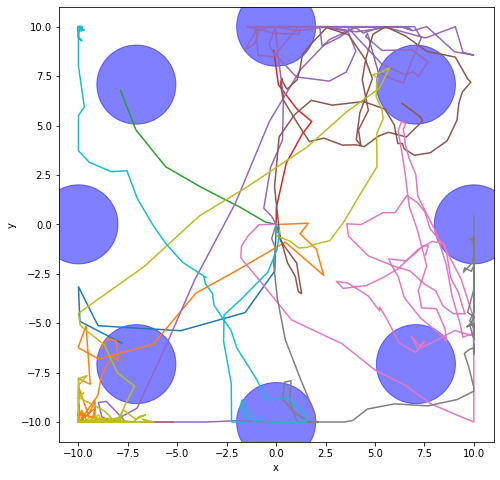

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
bounds = np.array([-10, 10, -10, 10])
aopy.visualization.plot_trajectories(cursor_trajectories[:10], bounds=bounds)
aopy.visualization.plot_targets(unique_targets, exp_metadata['target_radius'])

## Refactor out the data

## Finished time in seconds

# Post data analysis

In [34]:
import seaborn as sns


## Total finished trials

In [35]:
#calculate how many trials
for e in  exps: print(e.calc_state_occurrences('reward'))
print()

for e in  exps: print(e.calc_trial_num())

0
0

0
0


## Overall  trial statistics succuss rate)

In [36]:
import behaviour_metrics
import importlib

sns.set_context(context = 'talk')
importlib.reload(behaviour_metrics)

reward_events_per_minute = [behaviour_metrics.calc_event_rate_from_state_log(e.state_log,'reward',window_length=30) for e in exps]
reward_events_per_minute = np.array(reward_events_per_minute)

print(reward_events_per_minute)
plt.plot(reward_events_per_minute.T)
plt.legend(exp_conds, bbox_to_anchor=(1, -0.1))
plt.xlabel('Time (min)')
plt.ylabel('Rewards (#)')

TypeError: 'float' object cannot be interpreted as an integer

## Sort into trials

In [ ]:
state_log = e.state_log
segmented_trials = behaviour_metrics.segment_trials_in_state_log(state_log)

In [ ]:
trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']


for i in range(NUM_EXP):
    
    segmented_trials = behaviour_metrics.segment_trials_in_state_log(exps[i].state_log)

    task_data_hist_np = task_data_hist_np_all[i]
    trial_dict_0 = behaviour_metrics.sort_trials_use_segmented_log(segmented_trials, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

for t in trial_dicts_all: print(len(t))

# Behaviour  analyses

## Trajectory analysis

In [ ]:
import afs_plotting
importlib.reload(afs_plotting)

In [ ]:
figure_trajectory, axes_trajectory = plt.subplots(1, NUM_EXP, figsize = (NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE, 
                                                  GLOBAL_FIGURE_VERTICAL_SIZE)) 


n_roi_trials = 0

CIRCLE_RADIUS = exps[0].target_radius

print(CIRCLE_RADIUS)

for i,axes in enumerate(axes_trajectory): 

    afs_plotting.add_center_out_grid(axes, target_seq, CIRCLE_RADIUS)
    
    
    sample_trial = trial_dicts_all[i][n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    afs_plotting.plot_trial_trajectory(axes, trial_cursor_trajectory)

    axes.set_title(f'Trial {N_TRIALS} of {exp_conds[i]} ')



## Variance analysis

In [ ]:
importlib.reload(behaviour_metrics)

In [ ]:
arc_length = [behaviour_metrics.calc_arc_length_from_trial_dict(trial_dict) for trial_dict in trial_dicts_all]
for al in arc_length: plt.plot(al)
plt.legend(exp_conds)

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

## decoder

In [ ]:
from afs_plotting import plot_prefered_directions

TEXT_OFFSET_VERTICAL = -0.2


figure_decoder_C.suptitle('KF C matrix before and after CLDA')

print('steady state tuning curves:')

for  i,e in enumerate(exps): 

    e = exps[i]
    C = e.decoder.filt.C

    plot_prefered_directions(C, ax = axs_decoder_C[1,i])
    axs_decoder_C[1,i].set_title(f'{exp_conds[i]}')

figure_decoder_C

## Decoder compared to the encoder



In [ ]:
len(exps)

In [ ]:
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

active_feat_set = exps[2]._active_feat_set


for i,e in enumerate(exps):
    enc_directions = e.encoder.C
    dec_directions = np.array(e._used_C_mat_list)
    

    angles_hist = calc_cosine_to_target_matrix( dec_directions,enc_directions)
    
    if i == 0:
        active_angles = np.mean(angles_hist[:,noise_neuron_list], axis = 1)
        plt.plot(active_angles)
    
    active_angles = np.mean(angles_hist[:,active_feat_set], axis = 1)
    
    plt.plot(active_angles)



## looking at K matrix

In [ ]:
figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))

for i,e in enumerate(exps):
    K = (e._used_K_mat_list[1]).T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i])
    axes_k_matrix[0, i].set_title(exp_conds[i])

for i,e in enumerate(exps):
    K = (e._used_K_mat_list[-1]).T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i])
    axes_k_matrix[1,i].set_title(exp_conds[i])
    
    
figure_k_matrix.tight_layout()

# Feature analysis

In [ ]:
from matplotlib import colors



fig_feature_active_map, axes_feat_active_map = plt.subplots(1, NUM_EXP,
                                                            figsize = ( NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE,
                                                                      GLOBAL_FIGURE_VERTICAL_SIZE),
                                                           sharey = True)
axes_feat_active_map[0].set_ylabel('Learner Batch number')

#color true to yellow
cmap = colors.ListedColormap(['yellow'])

for i, exp in enumerate(exps):

    active_feat_heat_map = np.array(exp._active_feat_set_list, dtype = np.int32)
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    a = axes_feat_active_map[i].imshow(active_feat_heat_map, cmap = cmap)

    #color false to blue
    cmap.set_bad(color='blue')
    
    axes_feat_active_map[i].set_xlabel('All features')
    axes_feat_active_map[i].set_title(exp_conds[i])


#fig_feature_active_map.colorbar(a, ax=axes_feat_active_map.ravel().tolist())

## Examine used K mat

## examine used C mat

In [ ]:
import weights_linear_regression
importlib.reload(weights_linear_regression)
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis


figure_weights_norm, axes_weights_norm = plt.subplots( NUM_EXP, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE))

C_mat_all = list()

for j,exp in enumerate(exps):
    
    updated_C_mat = np.array(exp._used_C_mat_list)
    the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(updated_C_mat, debug = False)

    C_mat_all.append(np.copy(updated_C_mat))
    axe_exp = axes_weights_norm[j,:]
    for i,a in enumerate(axe_exp):
        a.plot(the_history_of_KF_weights_in_time_by_neurons[:, neuron_type_indices_in_a_list[i]])
        a.set_xlabel('Batch number')
        a.set_ylabel('Weight')
        
C_mat_all = np.array(C_mat_all)

In [ ]:
fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list
for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C=e.encoder.C,
                                                                indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
    
#axes_compr_means.set_title('Means of the high SNR weight trajectory')